In [6]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from xgboost import XGBRegressor 
from sklearn.model_selection import train_test_split  
from math import sqrt
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold


li = [pd.read_csv("dataset/marathon_results_2016.csv"), pd.read_csv("dataset/marathon_results_2017.csv"),
      pd.read_csv("dataset/marathon_results_2015.csv")]
df = pd.concat(li,axis=0,ignore_index=True)

def time_to_min(string):
    if string != '-':
        time_segments = string.split(':')
        hours = int(time_segments[0])
        mins = int(time_segments[1])
        sec = int(time_segments[2])
        time = hours*60 + mins + np.true_divide(sec,60)
        return time
    else:
        return -1

def gender_to_numeric(value):
    if value == 'M':
        return 0
    else:
        return 1

df['Half_min'] = df.Half.apply(lambda x: time_to_min(x))
df['Full_min'] = df['Official Time'].apply(lambda x: time_to_min(x))
df['split_ratio'] = (df['Full_min'] - df['Half_min'])/(df['Half_min'])

df_split = df[df.Half_min > 0]

df['5K_mins'] = df['5K'].apply(lambda x: time_to_min(x))
df['10K_mins'] = df['10K'].apply(lambda x: time_to_min(x))
df['10K_mins'] = df['10K_mins'] - df['5K_mins'] 

df['15K_mins'] = df['15K'].apply(lambda x: time_to_min(x))
df['15K_mins'] = df['15K_mins'] - df['10K_mins'] -  df['5K_mins']

df['20K_mins'] = df['20K'].apply(lambda x: time_to_min(x))
df['20K_mins'] = df['20K_mins'] -  df['15K_mins'] - df['10K_mins'] -  df['5K_mins']

df['25K_mins'] = df['25K'].apply(lambda x: time_to_min(x))
df['25K_mins'] = df['25K_mins'] - df['20K_mins'] -  df['15K_mins'] - df['10K_mins'] -  df['5K_mins']

df['30K_mins'] = df['30K'].apply(lambda x: time_to_min(x))
df['30K_mins'] = df['30K_mins'] -df['25K_mins'] - df['20K_mins'] -  df['15K_mins'] - df['10K_mins'] -  df['5K_mins']

df['35K_mins'] = df['35K'].apply(lambda x: time_to_min(x))
df['35K_mins'] = df['35K_mins'] -df['30K_mins'] -df['25K_mins'] - df['20K_mins'] -  df['15K_mins'] - df['10K_mins'] -  df['5K_mins']

df['40K_mins'] = df['40K'].apply(lambda x: time_to_min(x))
df['40K_mins'] = df['40K_mins'] -  df['35K_mins'] -df['30K_mins'] -df['25K_mins'] - df['20K_mins'] -  df['15K_mins'] - df['10K_mins'] -  df['5K_mins']

columns = ['20K_mins','15K_mins','10K_mins','5K_mins']
df['avg'] = df[columns].mean(axis = 1)
df['stdev'] = df[columns].std(axis = 1)

df_split = df[(~(df['5K'] == '-')) &(~(df['10K'] == '-'))&(~(df['15K'] == '-'))&(~(df['20K'] == '-'))&(~(df['25K'] == '-')) &(~(df['30K'] == '-')) &(~(df['35K'] == '-')) &(~(df['40K'] == '-'))]
df_split = df_split[df_split.split_ratio>0]


prediction_df = df_split[['Age','M/F', 'Half_min', 'Full_min','split_ratio','5K_mins','10K_mins','15K_mins','20K_mins','25K_mins', '30K_mins', '35K_mins','40K_mins', 'stdev']] 
prediction_df['M/F'] = prediction_df['M/F'].apply(lambda x: gender_to_numeric(x))

print(prediction_df)


       Age  M/F    Half_min    Full_min  split_ratio    5K_mins   10K_mins  \
0       21    0   66.750000  132.750000     0.988764  15.783333  15.550000   
1       26    0   66.766667  133.533333     1.000000  15.783333  15.566667   
2       31    0   66.733333  134.033333     1.008492  15.766667  15.566667   
3       33    0   66.766667  134.083333     1.008238  15.766667  15.583333   
4       23    0   66.766667  135.750000     1.033200  15.766667  15.583333   
...    ...  ...         ...         ...          ...        ...        ...   
79633   64    1  223.766667  458.933333     1.050946  50.250000  53.266667   
79634   61    1  227.916667  471.500000     1.068739  48.600000  51.050000   
79635   66    1  228.350000  479.550000     1.100066  53.050000  54.216667   
79636   53    0  223.583333  480.616667     1.149609  49.066667  51.133333   
79637   62    0  220.600000  486.016667     1.203158  40.233333  48.066667   

        15K_mins   20K_mins   25K_mins   30K_mins   35K_mins   

C:\Users\jonas\AppData\Local\Temp\ipykernel_10776\3394912097.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['M/F'] = prediction_df['M/F'].apply(lambda x: gender_to_numeric(x))


In [7]:

#----------------------------------------------------------------------------------------


INDATA = ['Age','5K_mins','M/F']


#--------------------------------------------------------------------------------------



X_train = prediction_df[INDATA]
y_train = prediction_df['Full_min']


linear_model = LinearRegression()
linear_cv_scores = cross_val_score(linear_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
linear_rmse_cv = np.sqrt(-linear_cv_scores.mean())

print('Linear Regression with Cross-Validation:')
print('Average RMSE:', linear_rmse_cv)

# XGBoost Regressor with Cross-Validation
xgb_model = XGBRegressor(n_estimators=2000, max_depth=5, learning_rate=0.005, reg_alpha=0.1, reg_lambda=0.1)
xgb_cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
xgb_rmse_cv = np.sqrt(-xgb_cv_scores.mean())

print('\nXGBoost Regressor with Cross-Validation:')
print('Average RMSE:', xgb_rmse_cv)

#------------------------------------------------------------------------------------

Linear Regression with Cross-Validation:
Average RMSE: 19.660556482459114

XGBoost Regressor with Cross-Validation:
Average RMSE: 20.21243672890645


In [8]:

traindf, testdf = train_test_split(prediction_df, test_size = 0.2,random_state=60)

X_train = traindf[INDATA]
y_train = traindf['Full_min']

X_test = testdf[INDATA]
y_test = testdf['Full_min']


XBG = XGBRegressor(n_estimators=2000, max_depth=5, learning_rate=0.005, reg_alpha=0.1, reg_lambda=0.1)
XBG.fit(X_train, y_train)

LinReg = LinearRegression()
LinReg.fit(X_train,y_train)

regression_prediction = LinReg.predict(X_test)
regression_error = regression_prediction - y_test
print('\nLinearRegression------------------------------')
print('R sqruare of regression...',LinReg.score(X_test,y_test))
print('RMSE of regression...',sqrt(mean_squared_error(y_test, regression_prediction)))


xgb_regression_prediction = XBG.predict(X_test)
xgb_regression_error = xgb_regression_prediction - y_test
print('\nXGBRegressor------------------------------')
print('Gradient Boosting Regression R Square...',XBG.score(X_test,y_test))
print('RMSE of Graident Bossting Regression...',sqrt(mean_squared_error(y_test, xgb_regression_prediction)))



LinearRegression------------------------------
R sqruare of regression... 0.7984226464541877
RMSE of regression... 18.691406023015205

XGBRegressor------------------------------
Gradient Boosting Regression R Square... 0.8020408341107839
RMSE of Graident Bossting Regression... 18.52289690593544


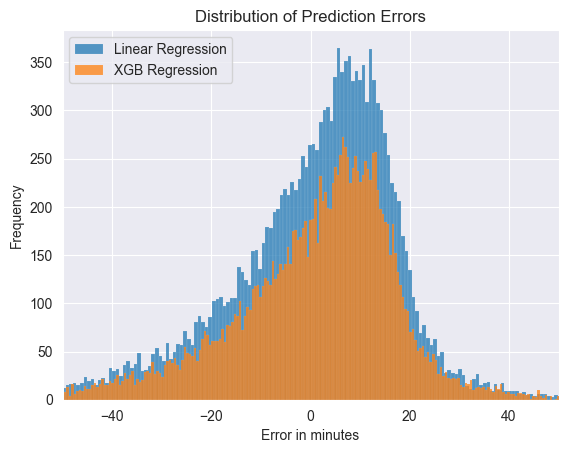

In [9]:

sns.histplot(regression_error, bins=500, kde=False, label='Linear Regression')
sns.histplot(xgb_regression_error, bins=500, kde=False, label='XGB Regression')
plt.xlim(-50, 50)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error in minutes')
plt.ylabel('Frequency')
plt.legend(['Linear Regression','XGB Regression'], loc = 2)
plt.show()

In [13]:

# Bias Variance Analysis
from mlxtend.evaluate import bias_variance_decomp

X_train = traindf[INDATA].values
y_train = traindf['Full_min'].values

X_test = testdf[INDATA].values
y_test = testdf['Full_min'].values

# Perform Bias-Variance analysis for Linear Regression
linear_model = LinearRegression()
linear_mse, linear_bias, linear_variance = bias_variance_decomp(linear_model, X_train, y_train, X_test, y_test, loss='mse', num_rounds=200, random_seed=1)

# Perform Bias-Variance analysis for XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=2000, max_depth=5, learning_rate=0.005, reg_alpha=0.1, reg_lambda=0.1)
xgb_mse, xgb_bias, xgb_variance= bias_variance_decomp(xgb_model, X_train, y_train, X_test, y_test, loss='mse', num_rounds=200, random_seed=1)

print('\nBias-Variance Analysis for Linear Regression:')
print('MSE:', linear_mse)
print('Bias:', linear_bias)
print('Variance:', linear_variance)

print('\nBias-Variance Analysis for XGBoost Regressor:')
print('MSE:', xgb_mse)
print('Bias:', xgb_bias)
print('Variance:', xgb_variance)



Bias-Variance Analysis for Linear Regression:
MSE: 349.3987560145129
Bias: 349.37072498596183
Variance: 0.028031028550976823

Bias-Variance Analysis for XGBoost Regressor:
MSE: 345.19733508163523
Bias: 342.2653789287655
Variance: 2.931956152869851
